### Data Usage
For this whole project, the Celeb-DF v2 dataset was used to train a CNN-LSTM model to predict whether a video is a deepfake or a real video.
The dataset is composed of:
* 590 real videos
* 5639 deepfakes.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from zipfile import ZipFile
from pathlib import Path

# Setup path to a data folder to store the data.
zip_path = Path("/content/drive/MyDrive/data.zip")
data_path = Path("data")

# If the data folder does not exist, download it and prepare it...
if not data_path.is_dir():
   data_path.mkdir(parents=True, exist_ok=True)

#
with ZipFile(zip_path, "r") as zip_ref:
   print("Unzipping video data")
   zip_ref.extractall(data_path)

Unzipping video data


In [5]:
from pathlib import Path
# Setup training, testing, and validation paths of the videos
videos_path = Path("/content/data/data/CelebDF(v2)")
train_vids_dir = videos_path / "train"
validation_vids_dir = videos_path / "validation"
test_vids_dir = videos_path / "test"
train_vids_dir, validation_vids_dir, test_vids_dir

(PosixPath('/content/data/data/CelebDF(v2)/train'),
 PosixPath('/content/data/data/CelebDF(v2)/validation'),
 PosixPath('/content/data/data/CelebDF(v2)/test'))

In [6]:
import os
from typing import Dict, List, Tuple
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in the target directories"""
    # 1. Get the class names by scanning the entire target directory
    classes = sorted([entry.name for entry in list(os.scandir(directory))])

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}...please check file structure")

    # 3. Create a list of index labels (computers perfer numbers over strings for labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx
find_classes(train_vids_dir.__str__())

(['fake', 'real'], {'fake': 0, 'real': 1})

### Turning Videos into Frames
Because videos are large and very difficult to process, they will be converted by their frames into images so that they can be stored effectively.
* It is much easier to apply transformations to stored images than it is to iterate through each video, through each frame of each video.
* Iterating though images can be done with 2-D Convolution, while iterating through videos would require expensive 3-D Convolution

In [7]:
!nvidia-smi

Sun Aug  3 22:22:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
!pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=89340cf4be8304856991d61f75b427329f768494b0b9ba0258ed44774408c074
  Stored in directory: /root/.cache/pip/wheels/56/30/c5/576bdd729f3bc062d62a551be7fefd6ed2f761901568171e4e
Successfully built ffmpeg


In [9]:
!ffmpeg -decoders | grep -i nvidia

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [10]:
!pip install torchcodec --index-url=https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.8/846.8 kB 789.8 kB/s eta 0:00:00


In [11]:
!pip install dlib

In [12]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=a1d2ab86003fe8e49b501cf5e2c4e30d26a56a147b043c7e15e213368580de49
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built face-recognition-models


torch.Size([3, 500, 942])


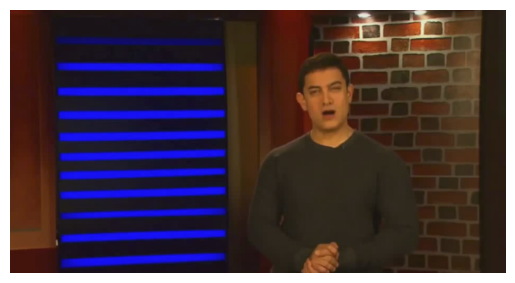

In [13]:
import matplotlib.pyplot as plt
from torchcodec.decoders import VideoDecoder
import torch

D = torch.device("cuda") if torch.cuda.is_available() else "cpu"

vd = VideoDecoder("/content/data/data/CelebDF(v2)/test/real/id0_0000.mp4", device="cuda")
i = 0
for frame in vd:  # type: ignore
    image = frame # Get one frame of the video to work with...
    break
plt.imshow(image.cpu().permute(1, 2, 0).numpy())
plt.axis(False)
print(image.shape)

### Preprocessing
Now that it is clearly possible to break up a video into frames, and then filter out the face from all their frames, a custom transform must be written so that videos are stored as a series of frames that are only then processed. Here is what must be processed:
* Write a custom transform sub-classing `torch.nn.Module` that in EACH directory,
    * Crops out the face of the person in the video
    * Breaks up the video into frames
    * Resizes all the frames to be of `shape [3, 64, 64]`
    * Converts all the frames into `torch.Tensor` objects

In [14]:
import face_recognition
import torch
from torch import nn
from torchvision.transforms import v2
from torchcodec.decoders import VideoDecoder

# Custom transform to crop out the face in every given frame...
class CropFaceOutOfImage(nn.Module):
    def forward(self, img):
        image = img.detach().clone().permute(1, 2, 0).cpu().numpy()
        locations = face_recognition.face_locations(img=image)
        if not locations: # Check if any faces were found
            return None # Return None if no faces are detected
        # Find and record face location.
        top, right, bottom, left = locations[0]
        # Crop the image
        image = v2.functional.crop(inpt=img, top=top, left=left, height=abs(top-bottom),
                           width=abs(right-left))
        return image

# Custom transform that applies all preprocessing needed for dataset/dataloader creation
# Includes CropFaceOutOfImage()
class PreprocessVideos(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        # Define transforms that can handle None values
        self.crop_face = CropFaceOutOfImage()
        self.post_crop_transforms = v2.Compose([
            v2.Resize(size=(64, 64)), # Resize to a smaller size
            v2.RandomHorizontalFlip(),
            v2.RandomPhotometricDistort(),
            # Convert to decimals
            v2.ToDtype(torch.float32, scale=True),
            # Then, normalize...
            v2.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], inplace=True)
            ])
        self.target_shape = (3, 16, 64, 64) # Define a target shape for the video tensor (channels, time, height, width)


    def forward(self, video: VideoDecoder) -> torch.Tensor | None:
        # Process the video frame-by-frame
        frames = []
        for frame in video:
            # Apply transforms to the frame
            cropped_frame = self.crop_face(frame)
            if cropped_frame is not None: # Only apply subsequent transforms if a face was detected
                transformed_frame = self.post_crop_transforms(cropped_frame)
                frames.append(transformed_frame)


        if not frames: # Return a tensor of zeros if no frames had detected faces
            print(f"Warning: No faces detected in video frames. Returning zero tensor.")
            return torch.zeros(self.target_shape)

        # Stack frames and resize the time dimension if necessary
        stacked_frames = torch.stack(frames, dim=1) # Shape: (C, T, H, W)
        if stacked_frames.shape[1] > self.target_shape[1]:
            # If there are more frames than the target time dimension, truncate
            stacked_frames = stacked_frames[:, :self.target_shape[1], :, :]
        elif stacked_frames.shape[1] < self.target_shape[1]:
            # If there are fewer frames, pad with zeros
            padding = torch.zeros(stacked_frames.shape[0], self.target_shape[1] - stacked_frames.shape[1], stacked_frames.shape[2], stacked_frames.shape[3], device=stacked_frames.device)
            stacked_frames = torch.cat([stacked_frames, padding], dim=1)

        return stacked_frames

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

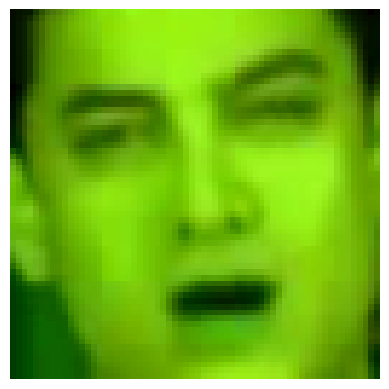

In [15]:
# Test the transforms method, and debug using cell output.
import matplotlib.pyplot as plt
video = VideoDecoder("/content/data/data/CelebDF(v2)/test/real/id0_0000.mp4", device="cuda")
transform = PreprocessVideos()
result_video = transform(video).permute(1, 2, 3, 0)
plt.imshow(result_video[0].cpu().numpy())
plt.axis(False)

In [16]:
import os
from typing import Dict, List, Tuple
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in the target directories"""
    # 1. Get the class names by scanning the entire target directory
    classes = sorted([entry.name for entry in list(os.scandir(directory))])

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}...please check file structure")

    # 3. Create a list of index labels (computers perfer numbers over strings for labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

## Storing the Data: Dataset and DataLoader
Now that the data can be appropriately transformed into tensors despite being video objects, it is time to create a dataset and a dataloader so that the model created to classify apart deepfakes from real videos. The goals for this section are the following:
1. Subclass torch.utils.data.Dataset
2. Init our subclass with a target directory (especially of we want to transform our data)
3. Create several attributes
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - the list of the target classes (or labels)
    * classes_to_idx - the dict of the class labels mapped to integer labels.
4. Create a function to load_images() to be able to load any image in the data.
5. Overwrite len() method to return the length of our dataset.
6. Overwrite get_item() to return a given sample when an index is passed.
7. Create datasets for training, testing, and validation sets.
8. Create dataloaders for training, validation, and testing using the created datasets in the prior steps.


In [17]:
import torch
from torch.utils.data import Dataset
from torchcodec.decoders import VideoDecoder
from pathlib import Path

# 1. Subclass torch.utils.data.Dataset
class VideoFolderCustom(Dataset):
    # 2. Initialize custom dataset
    def __init__(self, targ_dir: str, transform=None):
        super().__init__()
        # 3. Create (several) class attributes
        # paths
        self.paths = list(Path(targ_dir).glob("*/*.mp4"))
        # transform(s)
        self.transform = transform
        # Classes and classes to idx
        self.classes, self.classes_to_idx = find_classes(targ_dir)

    # 4. Create a function to load videos
    def load_video(self, idx: int) -> VideoDecoder:
        """Opens a video using a path and returns it."""
        video_path = self.paths[idx]
        return VideoDecoder(video_path, device="cuda")

    # 5. Overwrite __len__() method...
    def __len__(self) -> int:
        """Returns the total number of videos in the dataset"""
        return len(self.paths)

    # 6. Overwrite __get_item__() method...
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X, y)"""
        video = self.load_video(index)
        class_name = self.paths[index].parent.name
        class_idx = self.classes_to_idx[class_name]
        # Transforms
        transformed_video = self.transform(video) if self.transform else torch.tensor(video)
        # If transformed_video is None (which shouldn't happen with the updated PreprocessVideos),
        # handle it or raise an error. Given the change to return a zero tensor, this check
        # might be less necessary but keeping it for robustness.
        if transformed_video is None:
             # This case should ideally not be reached with the updated PreprocessVideos
             print(f"Error: transformed_video is None for {self.paths[index]}.")
             # Return a zero tensor and a placeholder label
             return torch.zeros(self.transform.target_shape), -1 # Using -1 as an invalid label

        return transformed_video, class_idx

In [18]:
# Creating the directories as strings
train_dir = train_vids_dir.__str__()
validation_dir = validation_vids_dir.__str__()
test_dir = test_vids_dir.__str__()
train_dir, validation_dir, test_dir

('/content/data/data/CelebDF(v2)/train',
 '/content/data/data/CelebDF(v2)/validation',
 '/content/data/data/CelebDF(v2)/test')

In [19]:
# Create the datasets for training, testing, validation
train_dataset = VideoFolderCustom(
    targ_dir=train_dir,
    transform=PreprocessVideos()
)
validation_dataset = VideoFolderCustom(
    targ_dir=validation_dir,
    transform=PreprocessVideos()
)
test_dataset = VideoFolderCustom(
    targ_dir=test_dir,
    transform=PreprocessVideos()
)
train_dataset, validation_dataset, test_dataset

(<__main__.VideoFolderCustom at 0x7cdeaf5ddad0>,
 <__main__.VideoFolderCustom at 0x7cde780cb4d0>)

In [20]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE: int = 32
# Create the dataloader from the datasets...
train_dl = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True
)
validation_dl = DataLoader(
    dataset=validation_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=False
)
test_dl = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=False
)
train_dl, validation_dl, test_dl

(<torch.utils.data.dataloader.DataLoader at 0x7cde78115510>,
 <torch.utils.data.dataloader.DataLoader at 0x7cde78115c10>)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

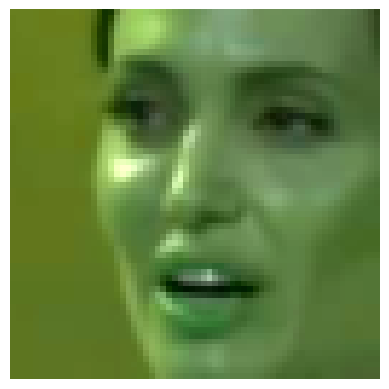

In [21]:
import matplotlib.pyplot as plt
# Testing: display a video frame from the validation set
torch.manual_seed(42)
video = validation_dataset[0][0]
plt.imshow(video.permute(1, 2, 3, 0)[0].cpu().numpy())
plt.axis(False)

In [22]:
import torch
from torch import nn
### First, coding the CNN class (TinyVGG architecture) so that LSTM can be focused on
# later...
class TinyVGG(nn.Module):
    def __init__(self, in_feats: int=3, hidden_feats: int=20, out_feats: int=3):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_feats, out_channels=hidden_feats, kernel_size=2,
                      stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_feats, out_channels=hidden_feats, kernel_size=2,
                      stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1, stride=1)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_feats, out_channels=hidden_feats, kernel_size=2,
                      stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_feats, out_channels=out_feats, kernel_size=2,
                      stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1, stride=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_block_2(self.conv_block_1(x))

In [23]:
# Test dummy input on tiny VGG to ensure it reduces size of frames from [256, 256, 3]
# to [64, 64, 3]
test_VGG = TinyVGG(in_feats=3, hidden_feats=10, out_feats=3)
input = torch.randn(100, 3, 256, 256)
test_VGG(input).shape

torch.Size([100, 3, 64, 64])

In [24]:
### Finally, coding the TinyVGG_LSTM architectured model...
class TinyVGG_LSTM(nn.Module):
    def __init__(self, conv_in_feats: int=3, conv_hidden_feats: int=20, conv_out_feats: int=3,
                 lstm_hidden_feats: int=16, lstm_layers: int=2,
                  lstm_input_size =(3, 64, 64)):
        super().__init__()
        self.cnn = TinyVGG(in_feats=conv_in_feats, hidden_feats=conv_hidden_feats,
                           out_feats=conv_out_feats)
      # Calculate flattened CNN output size for LSTM input
        dummy_input = torch.zeros(1, *lstm_input_size)
        with torch.no_grad():
            cnn_out = self.cnn(dummy_input)
        self.cnn_flatten_dim = cnn_out.view(1, -1).size(1)
        # Two-layer LSTM
        self.lstm = nn.LSTM(input_size=self.cnn_flatten_dim,
                            hidden_size=lstm_hidden_feats,
                            num_layers=lstm_layers,
                            batch_first=True)

        # Final binary classification
        self.fc = nn.Linear(lstm_hidden_feats, 1)

    def forward(self, x:torch.tensor):
        B, C, T, H, W = x.shape  # [batch, channels, time, height, width]
        x = x.view(B * T, C, H, W)

        cnn_features = self.cnn(x)
        cnn_features = cnn_features.view(B, T, -1)  # [B, T, features]

        lstm_out, _ = self.lstm(cnn_features)
        last_hidden = lstm_out[:, -1, :]  # Last frame output

        logits = self.fc(last_hidden)
        return torch.sigmoid(logits).squeeze(1)  # [B]

In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model_0 = TinyVGG_LSTM().to(device)
dummy_input = torch.randn(8, 3, 16, 64, 64).to(device)  # [B, T, C, H, W]
output = model_0(dummy_input)
print(output.shape)  # torch.Size([8])

torch.Size([8])


In [26]:
import torch
from torch import optim, nn
# Declare loss function and optimizer
# Remember, the dataset is imbalanced (5639 deepfakes, 590 real videos)
class_weights = torch.tensor([5639, 590])

loss_fn = nn.BCEWithLogitsLoss(weight=class_weights)
optimizer = optim.Adam(params=model_0.parameters(), lr=0.001)
loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [27]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 753.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [30]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
from tqdm.auto import tqdm
import numpy as np

def mca(num_classes:int, preds:torch.Tensor, labels:torch.Tensor) -> float:
    """Returns accuracy of predictions compared to labels in standard decimal (not percentage)
    form."""
    MCA = MulticlassAccuracy(num_classes=num_classes).to(preds.device)
    return MCA(preds, labels)
def mcf1(num_classes:int, preds:torch.Tensor, labels:torch.Tensor) -> float:
    """Returns the F1 Score of predictions compared to labels in standard decimal (not percentage)
    form.\n
    F1 is a measure of how accurate the model is in classification that combines the metrics
    of precision and recall."""
    MCF1 = MulticlassF1Score(num_classes=num_classes).to(preds.device)
    return MCF1(preds, labels)

### Creating a training loop: Usable with ANY model...
def train_step(seed:int, n:int, model: nn.Module, loss_fn: nn.Module,
               train_dl: DataLoader, optimizer: optim.Optimizer, batches_per_stats: int,
               D: torch.device | str = device) -> torch.Tensor:
    """Trains a model off a training dataloader that is assumed to have
    been created properly. \n n is the number of classes the model will be identifying...\n
    The device is set to use cuda and the gpu if it is available; otherwise, it is set to use the
    cpu. Both the loss function and optimizer must be defined before being passed as arguments
    here."""
    # Instantiating metrics list and metrics
    train_loss, train_acc, train_f1 = 0, 0, 0,
    # Set seed
    torch.manual_seed(seed) if D == "cpu" else torch.cuda.manual_seed(seed)
    # Put the model in training mode
    model.to(D)
    model.train()
    # Loop through training loop data
    for batch, (X, y) in enumerate(train_dl):
        # Device agnostic code
        X, y = X.to(D), y.to(D).float() # Cast target to float
        # 1. Forward pass
        y_preds = model(X)
        # 2. Calculate the loss (and update metrics)
        loss = loss_fn(y_preds, y)
        train_loss += loss.item()
        train_acc += mca(n, y_preds, y.long()) # Metrics expect long, cast back for calculation
        train_f1 += mcf1(n, y_preds, y.long()) # Metrics expect long, cast back for calculation
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Backpropogation
        loss.backward()
        # 5. Optimizer Step
        optimizer.step()
        ### Return progress update
        if batch % batches_per_stats == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dl.dataset)} Samples")
    # Update, store, and return metrics
    train_loss /= len(train_dl)
    train_acc /= len(train_dl)
    train_f1 /= len(train_dl)
    return torch.tensor([train_loss, train_acc, train_f1])

  ### Creating a testing loop: Usable with ANY model..
def test_step(n:int, model: nn.Module, loss_fn: nn.Module, test_dl: DataLoader,
              D: torch.device | str = device) -> torch.Tensor:
    """TESTS a model off a testing dataloader assumed to have
    been created properly. \n n is the number of classes the model will be identifying...\n
    The device is set to use cuda and the gpu if it is available; otherwise, it is set to use the
    cpu. Both the loss function and optimizer must be defined before being passed as arguments
    here."""
    test_loss, test_acc, test_f1 = 0, 0, 0
    # Put the model in testing mode after device agnostic code
    model.to(D)
    model.eval()
    # Loop through testing loop data with inference mode.
    with torch.inference_mode():
        for (X, y) in test_dl:
            # Device agnostic code
            X, y = X.to(D), y.to(D).float() # Cast target to float
            # 1. Forward Pass
            test_preds = model(X)
            # 2. Calculate the Loss and other metrics
            test_loss += loss_fn(test_preds, y).item()
            test_acc += mca(n, test_preds, y.long()) # Metrics expect long, cast back for calculation
            test_f1 += mcf1(n, test_preds, y.long()) # Metrics expect long, cast back for calculation
        # Adjust and return metrics
        test_loss /= len(test_dl)
        test_acc /= len(test_dl)
        test_f1 /= len(test_dl)
    return torch.tensor([test_loss, test_acc, test_f1])

def run_epochs(epochs: int, n:int, epochs_per_stats: int, batches_per_status: int, seed: int,
               model: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer,
               train_dl: DataLoader, test_dl: DataLoader) -> np.ndarray:
    # Create metrics lists to store all metrics
    epoch_count, losses, accs, f1s, test_losses, test_accs, test_f1s = [], [], [], [], [], [], []
    # Start the epochs
    for epoch in tqdm(range(epochs)):
        # Record training metrics and train the model
        training_metrics = train_step(seed=seed, n=n, model=model, loss_fn=loss_fn, train_dl=train_dl,
                                   optimizer=optimizer, batches_per_stats=batches_per_status)
        epoch_count.append(epoch)
        losses.append(training_metrics[0])
        accs.append(training_metrics[1])
        f1s.append(training_metrics[2])
        # Record testing metrics and test the model
        testing_metrics = test_step(n=n, model=model, loss_fn=loss_fn, test_dl=test_dl)
        test_losses.append(testing_metrics[0])
        test_accs.append(testing_metrics[1])
        test_f1s.append(testing_metrics[2])
        # Print out what's happening
        if epoch % epochs_per_stats == 0:
            print(f"Training Loss: {losses[epoch]:.4f} | Accuracy: {accs[epoch]:.4f}% | F1 Score: {f1s[epoch]:.4f} | Test Loss: {test_losses[epoch]:.4f} | Test Accuracy: {test_accs[epoch]:.4f}% | Test F1 Score: {test_f1s[epoch]:.4f}")
    result_tensor = torch.tensor([epoch_count, losses, accs, f1s, test_losses, test_accs, test_f1s])
    return result_tensor.cpu().numpy()

In [31]:
# Modify the training loop to handle None values returned by the dataset
def run_epochs_modified(epochs: int, n:int, epochs_per_stats: int, batches_per_status: int, seed: int,
               model: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer,
               train_dl: DataLoader, test_dl: DataLoader) -> np.ndarray:
    # Create metrics lists to store all metrics
    epoch_count, losses, accs, f1s, test_losses, test_accs, test_f1s = [], [], [], [], [], [], []
    # Start the epochs
    for epoch in tqdm(range(epochs)):
        # Record training metrics and train the model
        training_metrics = train_step(seed=seed, n=n, model=model, loss_fn=loss_fn, train_dl=train_dl,
                                   optimizer=optimizer, batches_per_stats=batches_per_status)
        epoch_count.append(epoch)
        losses.append(training_metrics[0])
        accs.append(training_metrics[1])
        f1s.append(training_metrics[2])
        # Record testing metrics and test the model
        testing_metrics = test_step(n=n, model=model, loss_fn=loss_fn, test_dl=test_dl)
        test_losses.append(testing_metrics[0])
        test_accs.append(testing_metrics[1])
        test_f1s.append(testing_metrics[2])
        # Print out what's happening
        if epoch % epochs_per_stats == 0:
            print(f"Training Loss: {losses[epoch]:.4f} | Accuracy: {accs[epoch]:.4f}% | F1 Score: {f1s[epoch]:.4f} | Test Loss: {test_losses[epoch]:.4f} | Test Accuracy: {test_accs[epoch]:.4f}% | Test F1 Score: {test_f1s[epoch]:.4f}")
    result_tensor = torch.tensor([epoch_count, losses, accs, f1s, test_losses, test_accs, test_f1s])
    return result_tensor.cpu().numpy()

run_epochs_modified(epochs=10, n=2, loss_fn=loss_fn, batches_per_status=200, seed=42, optimizer=optimizer,
           train_dl=train_dl, test_dl=validation_dl, model=model_0, epochs_per_stats=1)

  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (32) must match the size of tensor b (2) at non-singleton dimension 0